In [52]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from utils import move_last_two_months_first

def make_example_storm_outputs_figure(mean_decadal_counts):

    output = move_last_two_months_first(mean_decadal_counts)
    
    month_strings = ["November", "December", "January", "February", "March", "April"]

    fig, axes = plt.subplots(5, 6, figsize=(20,15), layout="compressed", subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # Add transparent land by creating a custom feature
    land_shp = natural_earth(resolution='110m', category='physical', name='land')
    land_feature = ShapelyFeature(Reader(land_shp).geometries(),
                                  ccrs.PlateCarree(), facecolor='lightgray', edgecolor='face', alpha=0.5)
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    # Add countries boundaries and labels
    countries_shp = natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    countries_feature = ShapelyFeature(Reader(countries_shp).geometries(), ccrs.PlateCarree(),
                                       facecolor='none', edgecolor='black', linewidth=1, alpha=1)

    pc = np.empty((5, 6), dtype=object)
    for category in range(1, 6):
        for month in range(6):
            
            ax = axes[category - 1, month]
            ax.add_feature(land_feature)
            ax.add_feature(countries_feature)
            ax.add_feature(states_provinces, edgecolor='gray')

            ax.set_xticks([])
            ax.set_yticks([])

            val = np.flipud(output[:, :, month, category])
            # Plot gradient for model prediction on top of the land feature
            lonplot2 = np.linspace(135, 240, val.shape[1])
            latplot2 = np.linspace(-5, -60, val.shape[0])
            
            # Use a continuous colormap
            pc[category-1][month] = ax.contourf(lonplot2, latplot2, val, levels=100, cmap='summer', transform=ccrs.PlateCarree())
            
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              linewidth=1, color='white', alpha=0.3, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            ax.set_extent([135, 240, -60, -5], crs=ccrs.PlateCarree())

    for month in range(6):
        ax = axes[0, month]
        ax.set_title(month_strings[month], pad=15)
        # Add gridlines with labels
        
        
        gl.xlocator = mticker.FixedLocator([-180, -160, -140, -90, -45, 0, 45, 90, 140, 160, 180, 225, 270, 315, 360])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 12, 'color': 'black'}
        gl.ylabel_style = {'size': 12, 'color': 'black'}
            
        # Adjust map extent to focus on the region of interest
    
    for category in range(1, 6):
        ax = axes[category - 1, 0]
        ax.set_ylabel(f"Category {category}", rotation=0, ha='right', labelpad=50)
        
        fig.colorbar(pc[category-1][2], ax=axes[category-1, :])
    
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.show()
    
def load_example_mean_decadal_count(data_folder):
    files = glob.glob(os.path.join(data_folder, "*.hdf5"))
    if len(files) < 1:
        return
        
    with h5py.File(files[0], 'r+') as file:
        grid = file['train_grids'][0]
        print(np.array(grid).shape)
        print(np.max(grid))
        grid = np.array(grid[-1])
        print(np.count_nonzero(grid))
        print(np.max(np.sum(grid, axis=-2)))
        return grid


(10, 110, 210, 6, 6)
1.4
523010
4.16


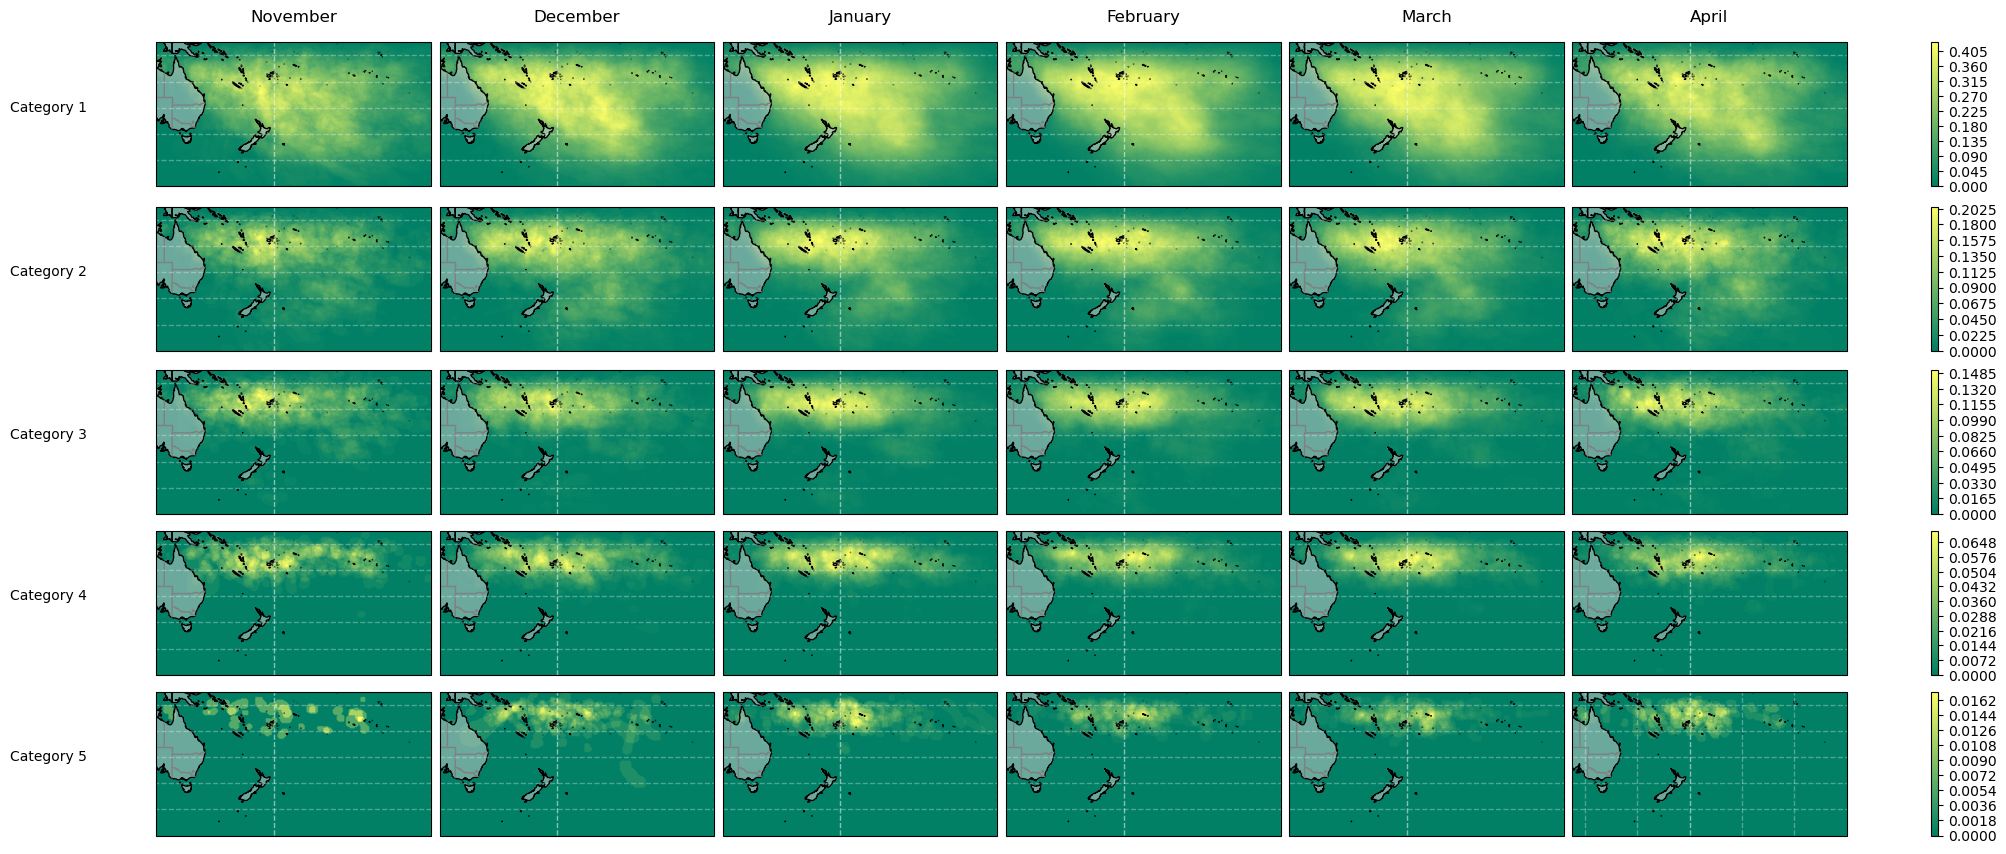

In [53]:
data_folder  = "/users/ewinkelm/data/ewinkelm/"

mean_decadal_count = load_example_mean_decadal_count(data_folder)

make_example_storm_outputs_figure(mean_decadal_count)